In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

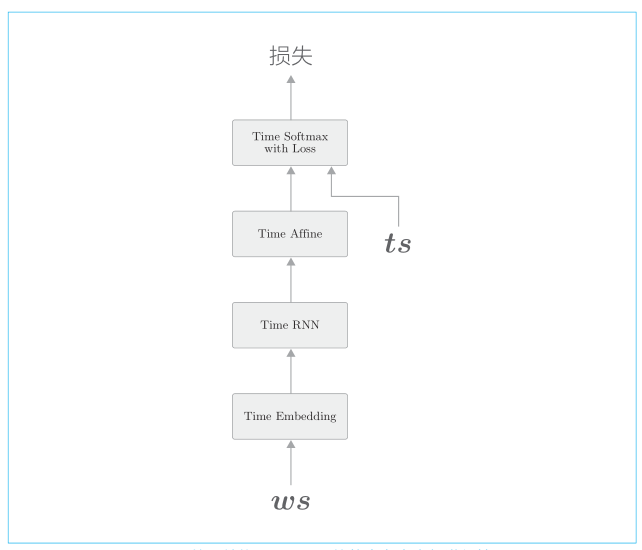

N = batch_size
N, T = ws.shape
N, T, D = (Time Embedding out).shape
N, T, H = (Time RNN out).shape
N, T ,V = (Time Affine out).shape (预测的下一个位置为对应单词表的各个单词的得分)
N, T, V = (TimeSoftmaxWithLoss out).shpae (预测的下一个位置为对应单词表的各个单词的概率)

因为每一层的权重与batch_size没有关系，并且Time XX内部的共享权重，因此与T也没有关系，因此init的时候只需要传入D,H,V即可，N,T在forward时由输入数据的属性指定

In [1]:
class SimpleRnnlm:
    def __init__(self, vocab_size,  wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 初始化权重
        embed_W  = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')  # Xaiver初始值
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1] # 为了后面清除state
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()